<a href="https://colab.research.google.com/github/MendasD/CertificatIA_ForceN/blob/main/Identification_des_cas_de_paludisme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identification des cas de paludisme**

Ce projet consiste à developper un modèle qui permettra d'identifier les personnes atteint de paludisme, à partir d'une image d'une cellule sanguine, qui sera donnée comme input au modèle. Pour ce faire, nous mettrons en place un modèle de computer vision, que nous entraînerons à partir du jeu de données spécifié dans la consigne du projet.

## **Importations des modules nécessaires**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

## **Importation du jeu de données depuis kaggle**

In [ ]:
from google.colab import files
files.upload()  # Téléverse le fichier kaggle.json

{}

In [ ]:
#Installation du kpi de kaggle
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Importation du fichier zippé contenant les images
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 98% 662M/675M [00:05<00:00, 140MB/s]
100% 675M/675M [00:05<00:00, 124MB/s]


In [ ]:
# Dézipper le dossier
import zipfile
zip_path = "cell-images-for-detecting-malaria.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("malaria_dataset") # Extraire dans le dossier malaria_dataset

In [ ]:
#Vérification du contenu du dossier
import os
dataset_dir = "/content/malaria_dataset/cell_images"
print(os.listdir(dataset_dir))

['cell_images', 'Parasitized', 'Uninfected']


In [ ]:
#Remarque : On a pas besoin du dossier cell images on va procéder à sa suppression
import shutil

dossier_a_supprimer = os.path.join(dataset_dir, "cell_images")
if os.path.exists(dossier_a_supprimer):
    shutil.rmtree(dossier_a_supprimer)
    print(f"Dossier {dossier_a_supprimer} supprimé.")
else:
    print("Aucun dossier supplémentaire trouvé.")

print(os.listdir(dataset_dir))

Dossier /content/malaria_dataset/cell_images/cell_images supprimé.
['Parasitized', 'Uninfected']


In [ ]:
#Accès aux images
parasitized_dir = os.path.join(dataset_dir, "Parasitized")
uninfected_dir = os.path.join(dataset_dir, "Uninfected")

Notre jeu de donnée contient un nombre égal d'images de cellules infectées et non infectées, valant **13 780**.

Nombre d'images infectées : 13780
Nombre d'images non infectées : 13780
Nous pouvons déduire que la base est équilibrée car nous avons autant d'images infectées que d'images non infectées


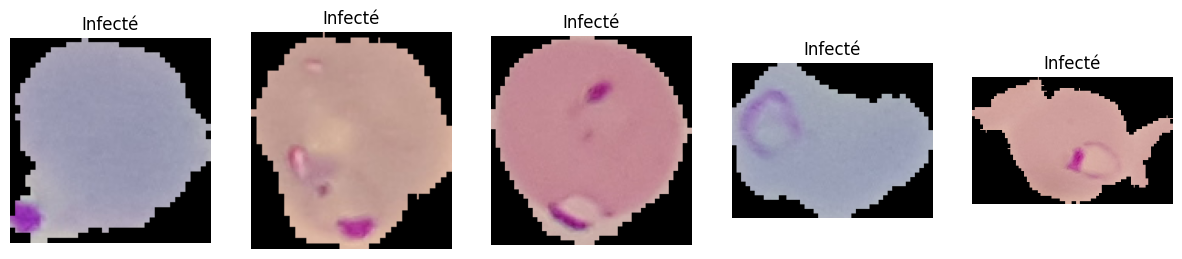

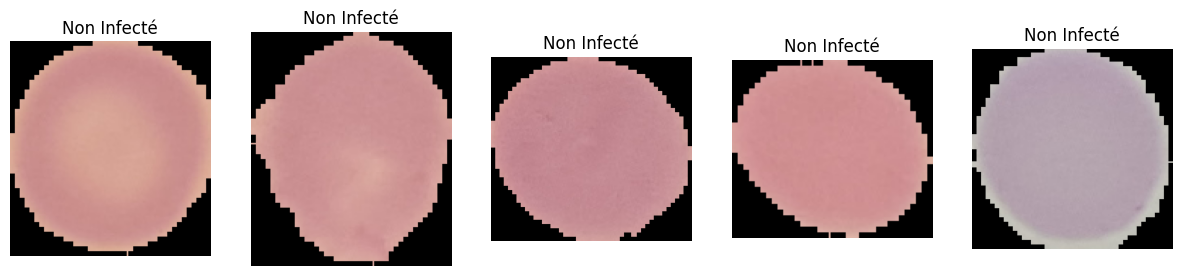

In [ ]:
#Affichage de 5 images infectées et non infectées
def plot_images(image_folder, title, num_images=5):
    plt.figure(figsize=(15, 15))
    images = os.listdir(image_folder)[:num_images]  # Prend les premières `num_images` images
    for i, img_name in enumerate(images):
        img_path = os.path.join(image_folder, img_name)
        img = plt.imread(img_path)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.show()
print(f"Nombre d'images infectées : {len(os.listdir(parasitized_dir))}")
print(f"Nombre d'images non infectées : {len(os.listdir(uninfected_dir))}")
print(f"Nous pouvons déduire que la base est équilibrée car nous avons autant d'images infectées que d'images non infectées")
# Afficher des images infectées
plot_images(parasitized_dir, "Infecté", num_images=5)

# Afficher des images non infectées
plot_images(uninfected_dir, "Non Infecté", num_images=5)

##**Préparation des données**

In [ ]:
# Paramètres
img_size = (64, 64)  # Taille des images
batch_size = 32

# Générateur de données
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalisation des pixels
    validation_split=0.2,  # Séparation des données en entraînement et validation
    rotation_range=20,     # Augmentation des données
    zoom_range=0.2,
    horizontal_flip=True
)

# Charger les données d'entraînement et de validation
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


##**Création du modèle**

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")  # Sortie binaire
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

##**Entrainement du modèle**

In [ ]:
epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 438s 316ms/step - accuracy: 0.2479 - loss: -699533950976.0000 - val_accuracy: 0.2500 - val_loss: -22238151573504.0000
Epoch 2/10
   1/1377 ━━━━━━━━━━━━━━━━━━━━ 4:09 181ms/step - accuracy: 0.1250 - loss: -50049513947136.0000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1377/1377 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - accuracy: 0.1250 - loss: -50049513947136.0000 - val_accuracy: 0.2501 - val_loss: -22315148509184.0000
Epoch 3/10
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 431s 313ms/step - accuracy: 0.2532 - loss: -81848176738304.0000 - val_accuracy: 0.2501 - val_loss: -481940226441216.0000
Epoch 4/10
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - accuracy: 0.3125 - loss: -330656378781696.0000 - val_accuracy: 0.2499 - val_loss: -482734661173248.0000
Epoch 5/10
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 443s 322ms/step - accuracy: 0.2496 - loss: -866880428441600.0000 - val_accuracy: 0.2501 - val_loss: -2499895378313216.0000
Epoch 6/10
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - accuracy: 0.2188 - loss: -1781722890895360.0000 - val_accuracy: 0.2500 - val_loss: -2498963907280896.0000
Epoch 7/10
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 420s 305ms/step - accuracy: 0.2499 - loss: -3694772728365056.0000 - val_accuracy: 0.2497 - val_loss: -7713404781330432.0000
Epoch 8/10
1377/1377 ━━━━━━━━━━

## **Réalisation d'un modèle de neuronnes convolutifs (CNN)**

### **Vérification de l'extension des images**

Dans cette partie, nous voulons garantir que chaque fichier de notre dataset a une extension correcte (**png, jpg, jpeg ou bmp**). Les fichiers n'ayant aucune de ces extensions seront donc supprimés du dataset.

In [ ]:
extensions_correctes = ['png','jpg','jpeg','bmp']

In [ ]:
import cv2
import imghdr

for classe_image in os.listdir(dataset_dir):
    classe_dir = os.path.join(dataset_dir, classe_image)
    for image_name in os.listdir(classe_dir):
        image_path = os.path.join(classe_dir, image_name)
        try:
          img = cv2.imread(image_path)
          img_type = imghdr.what(image_path)
          if img_type not in extensions_correctes:
              print(f"L'image {image_path} a une extension incorrecte.")
              os.remove(image_path)
        except Exception as e:
            print(f"Erreur lors de la lecture de l'image {image_path}: {e}")


<ipython-input-12-396eac847244>:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


L'image /content/malaria_dataset/cell_images/Parasitized/Thumbs.db a une extension incorrecte.
L'image /content/malaria_dataset/cell_images/Uninfected/Thumbs.db a une extension incorrecte.


### **Preprocessing**

In [ ]:
# informations sur la fonction
tf.keras.utils.image_dataset_from_directory??

In [ ]:
# Chargement des données
data = tf.keras.utils.image_dataset_from_directory(dataset_dir, image_size=(256, 256), batch_size=32, shuffle=True)

print(len(data))

Found 27558 files belonging to 2 classes.
862


In [ ]:
# Transformation de l'objet data en un objet iterable
data_iter = data.as_numpy_iterator()

batch = data_iter.next()
print(len(batch)) # chaque batch a deux composantes: les images et les labels

2


In [ ]:
# Affichage de la taille des images
print(batch[0].shape)

# Affichage des labels
print(batch[1])

(32, 256, 256, 3)
[0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0]


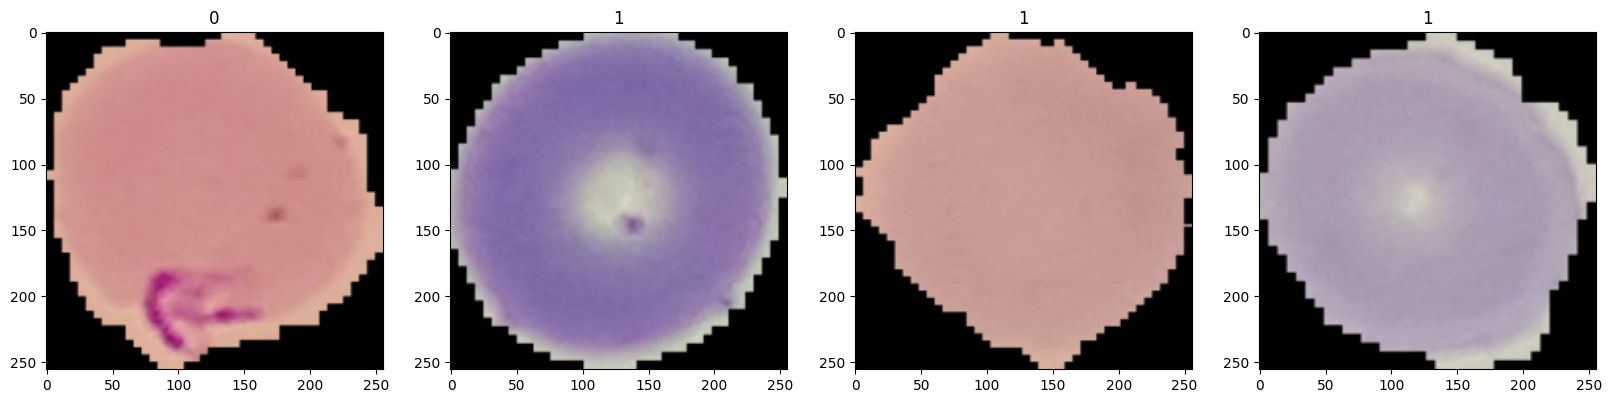

In [ ]:
# Identification des labels des differentes classes
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i, img in enumerate(batch[0][:4]):
    ax[i].imshow(img.astype(int))
    ax[i].title.set_text(batch[1][i])

# On voit alors que 1 : classe non infectée et 0 : classe infectée

### **Normaliser les images**

Nous allons normaliser chaque image, afin de ramener chaque pixel entre **0 et 1**. Pour ce faire, nous diviserons chaque pixel par **255**, qui est la valeur maximal d'un pixel.

In [ ]:
# Affichage du pixel minimal et maximal
print(f"pixel min : {np.min(batch[0])}")
print(f"pixel max : {np.max(batch[0])}")

pixel min : 0.0
pixel max : 237.621337890625


In [ ]:
data_scaled = data.map(lambda x,y: (x/255, y))

print(f"pixel min : {np.min(data_scaled.as_numpy_iterator().next()[0])}")
print(f"pixel max : {np.max(data_scaled.as_numpy_iterator().next()[0])}")

pixel min : 0.0
pixel max : 0.9583821296691895


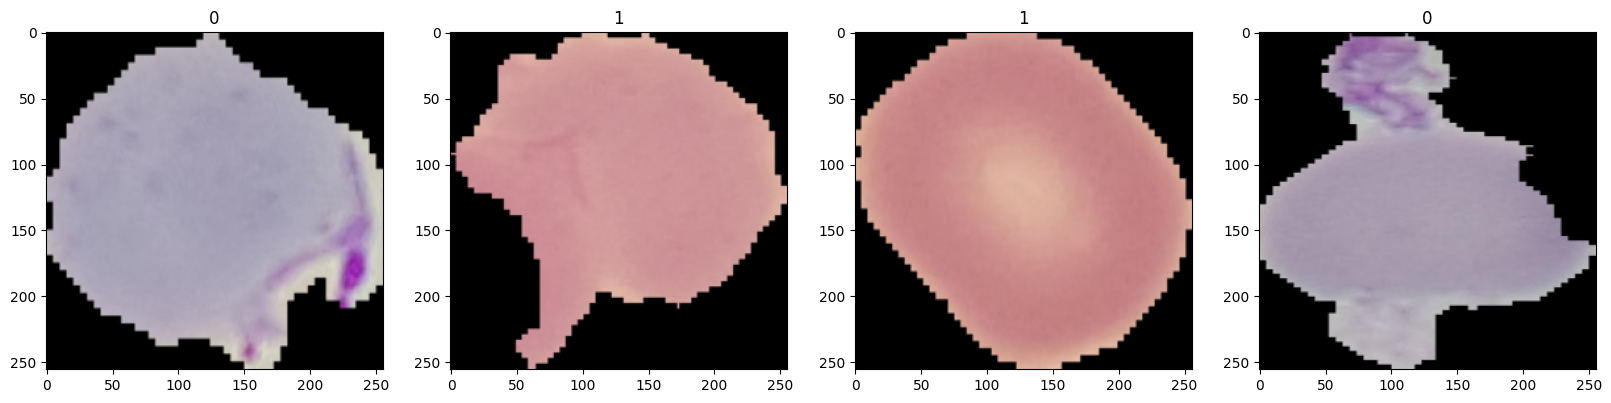

In [ ]:
# Transformer les nouvelles données en un objet iterable
data_scaled_iter = data_scaled.as_numpy_iterator()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i, img in enumerate(data_iter.next()[0][:4]):
    ax[i].imshow(img.astype(int))
    ax[i].title.set_text(data_iter.next()[1][i])

### **Séparation des données**

Il s'agira ici, de diviser notre jeu de données en **3 échantillons**:

- un échantillon d'entraînement (**training**),

- un échantillon de validation,

- un échantillon de test (**testing**).

In [ ]:
# Nombre de batch
print(len(data_scaled))

862


In [ ]:
train_size = int(len(data_scaled)*.7) + 1 # +1 c'est juste pour récupérer tous les 862 batchs
val_size = int(len(data_scaled)*.2)
test_size = int(len(data_scaled)*.1)

print(f"train size : {train_size}")
print(f"val size : {val_size}")
print(f"test size : {test_size}")
print(f"total : {train_size+val_size+test_size}")

train size : 604
val size : 172
test size : 86
total : 862


In [ ]:
# Division du jeu de données
data_train = data_scaled.take(train_size)
data_val = data_scaled.skip(train_size).take(val_size)
data_test = data_scaled.skip(train_size+val_size).take(test_size)

print(f"train size : {len(data_train)}")
print(f"val size : {len(data_val)}")
print(f"test size : {len(data_test)}")

train size : 604
val size : 172
test size : 86


### **Construction du modèle**

In [ ]:
# Initialisation d'un modèle séquentiel
model_cnn = Sequential()

In [ ]:
# Ajout d'autres couches
model_cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(256,256,3)))
model_cnn.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model_cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model_cnn.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model_cnn.add(Flatten()) # Applatissement de l'image

model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid')) # couche final

In [ ]:
# Compilation du modèle
model_cnn.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 61, 61, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 15376)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,936,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,951,537 (15.07 MB)

 Trainable params: 3,951,537 (15.07 MB)

 Non-trainable params: 0 (0.00 B)

### **Training**

In [ ]:
# Chemin pour les fichier logs
logdir='logs'
# Enregistrer les métriques d'entraînement et de validation dans le dossier logs.
tensor_callbacks = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# Entraînement du modèle
hist = model_cnn.fit(data_train, epochs=3, validation_data=data_val, callbacks=[tensor_callbacks])

Epoch 1/3
604/604 ━━━━━━━━━━━━━━━━━━━━ 1913s 3s/step - accuracy: 0.8000 - loss: 0.4353 - val_accuracy: 0.9322 - val_loss: 0.2306
Epoch 2/3
604/604 ━━━━━━━━━━━━━━━━━━━━ 1744s 3s/step - accuracy: 0.9404 - loss: 0.1938 - val_accuracy: 0.9482 - val_loss: 0.1633
Epoch 3/3
604/604 ━━━━━━━━━━━━━━━━━━━━ 1723s 3s/step - accuracy: 0.9496 - loss: 0.1554 - val_accuracy: 0.9466 - val_loss: 0.1739


### **Performances du modèle**

In [ ]:
# Historique de l'entraînement et validation pour les différentes epochs
hist.history

{'accuracy': [0.8842094540596008, 0.9451055526733398, 0.9500724077224731],
 'loss': [0.3028038442134857, 0.17862001061439514, 0.15461456775665283],
 'val_accuracy': [0.9322311282157898, 0.9482194781303406, 0.9465842843055725],
 'val_loss': [0.2306261658668518, 0.16331006586551666, 0.17387564480304718]}

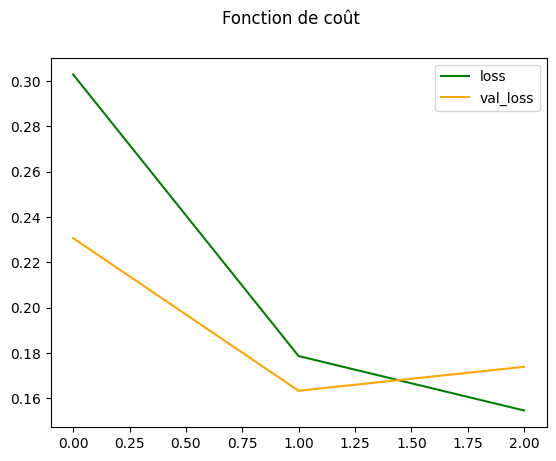

In [ ]:
# Fonction de perte
fig = plt.figure()
plt.plot(hist.history['loss'], color='green', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.suptitle("Fonction de coût")
plt.legend(loc = "upper right")
plt.show()

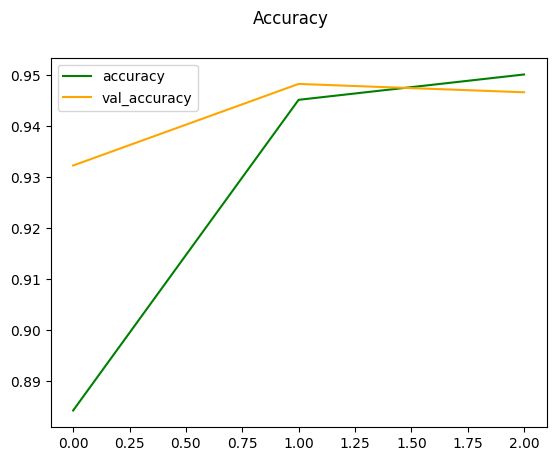

In [ ]:
# Accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.suptitle("Accuracy")
plt.legend(loc = "upper left")
plt.show()

### **Testing**

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [ ]:
for batch in data_test.as_numpy_iterator():
    X, y = batch
    y_pred = model_cnn.predict(X)
    precision.update_state(y, y_pred) # Met à jour la métrique
    recall.update_state(y, y_pred)
    accuracy.update_state(y, y_pred)

print(f"precision : {precision.result().numpy()}")
print(f"recall : {recall.result().numpy()}")
print(f"accuracy : {accuracy.result().numpy()}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/ste

## **Sauvegarde du modèle**

In [ ]:
model_cnn.save('malaria_cnn.h5')
model_cnn.save('malaria_cnn.keras')

## **Conclusion**

Le modèle mis sur pied est un modèle **CNN**, qui est spécialement adapté pour la manipulation d'images. Le modèle obtenu possède **9 couches** et **3,951,537 paramètres**. Globalement, les performances de ce modèle sont plutôt satisfaisantes, avec un **accuracy** de **0,949** pour l'échantillon d'entraînement contre **0,946** pour l'échantillon de validation.